<h1> Diabetes prediction model </h1>

In [3]:
#import libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split,GridSearchCV 
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.decomposition import PCA


In [4]:
demo = pd.read_csv(".//Data//demographic.csv")
diet = pd.read_csv(".//Data//diet.csv")
exam = pd.read_csv(".//Data//examination.csv")
quest = pd.read_csv(".//Data//questionnaire.csv")
lab = pd.read_csv(".//Data//labs.csv")

In [5]:
#creating the data frame
demo = demo.loc[:,['SEQN','RIAGENDR','INDFMPIR']]
lab = lab.loc[:,['LBXGH','SEQN']]
exam=exam.loc[:,['SEQN','BMXARMC','BMDAVSAD','MGDCGSZ']]


In [6]:
df = demo.merge(lab,on = 'SEQN').merge(exam,on='SEQN')

In [7]:
df.head(10)

,SEQN,RIAGENDR,INDFMPIR,LBXGH,BMXARMC,BMDAVSAD,MGDCGSZ
0,73557,1,0.84,13.9,35.3,20.6,55.2
1,73558,1,1.78,9.1,34.7,24.4,61.5
2,73559,1,4.51,8.9,33.5,25.6,91.0
3,73560,1,2.52,NaN,21.0,14.9,32.2
4,73561,2,5.00,4.9,25.2,NaN,30.9
5,73562,1,4.79,5.5,41.8,29.1,53.1
6,73563,1,5.00,NaN,14.9,NaN,NaN
7,73564,2,5.00,5.5,38.0,26.7,45.9
8,73566,2,0.48,5.4,29.0,19.9,38.8
9,73567,1,1.20,5.2,27.5,20.0,43.5


In [8]:
df.shape

(9813, 7)

In [9]:
df= df[df['LBXGH'].notna()]
df.isna().sum()
df.dropna(inplace=True) #only a few nan values (506)


In [10]:
df = df.rename(columns = {'SEQN' : 'ID',
                          'RIAGENDR' : 'Gender',
                          'DMDYRSUS' : 'Years_in_US', # Nan -> american i guess
                          'INDFMPIR' : 'Family_income',
                          'LBXGH' : 'GlycoHemoglobin',
                          'BMXARMC' : 'ArmCircum',
                          'BMDAVSAD' : 'SaggitalAbdominal',
                          'MGDCGSZ' : 'GripStrength',
                          'DRABF' : 'Breast_fed'})

<h1>Some Feature engineering</h1>

In [11]:
#LBXGH is the hormone indicating the presence of  diabetes 0->no diabetes 1->high risk
df.loc[df['GlycoHemoglobin'] < 6.0, 'Diabetes'] = 0
df.loc[df['GlycoHemoglobin'] >= 6.0, 'Diabetes'] = 1

In [12]:
df.drop('GlycoHemoglobin',axis = 1, inplace= True)

In [13]:
df.head(10)

,ID,Gender,Family_income,ArmCircum,SaggitalAbdominal,GripStrength,Diabetes
0,73557,1,0.84,35.3,20.6,55.2,1.0
1,73558,1,1.78,34.7,24.4,61.5,1.0
2,73559,1,4.51,33.5,25.6,91.0,1.0
5,73562,1,4.79,41.8,29.1,53.1,0.0
7,73564,2,5.00,38.0,26.7,45.9,0.0
8,73566,2,0.48,29.0,19.9,38.8,0.0
9,73567,1,1.20,27.5,20.0,43.5,0.0
10,73568,2,5.00,25.8,14.5,61.0,0.0
12,73571,1,5.00,36.5,29.7,83.8,1.0
15,73574,2,2.10,26.5,15.1,71.4,0.0


In [14]:
df["Diabetes"].value_counts()


0.0    4452
1.0     894
Name: Diabetes, dtype: int64

<p>We can notice that there is class imbalance </p>

<h1>EDA</h1>

In [15]:
df.describe()

,ID,Gender,Family_income,ArmCircum,SaggitalAbdominal,GripStrength,Diabetes
count,5346.000000,5346.000000,5346.000000,5346.000000,5346.000000,5346.000000,5346.000000
mean,78671.054807,1.499626,2.446079,32.335484,21.884138,70.391152,0.167228
std,2924.571130,0.500047,1.646306,5.453655,4.717888,21.800635,0.373214
min,73557.000000,1.000000,0.000000,18.200000,11.900000,14.800000,0.000000
25%,76174.500000,1.000000,1.020000,28.500000,18.200000,54.000000,0.000000
50%,78692.500000,1.000000,2.020000,32.000000,21.400000,66.300000,0.000000
75%,81175.500000,2.000000,3.930000,35.700000,24.900000,85.900000,0.000000
max,83729.000000,2.000000,5.000000,57.000000,40.100000,162.800000,1.000000


<h2>Feature distribution</h2>

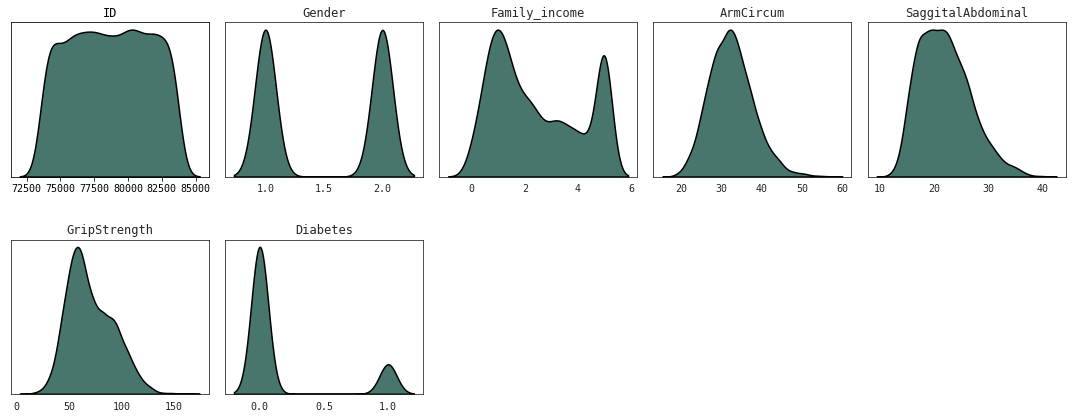

In [16]:
fig = plt.figure(figsize = (15, 60))
for i in range(len(df.columns.tolist())):
    plt.subplot(20,5,i+1)
    sns.set_style("white")
    plt.title(df.columns.tolist()[i], size = 12, fontname = 'monospace')
    a = sns.kdeplot(df[df.columns.tolist()[i]], color = '#34675c', shade = True, alpha = 0.9, linewidth = 1.5, edgecolor = 'black')
    plt.ylabel('')
    plt.xlabel('')
    plt.xticks(fontname = 'monospace')
    plt.yticks([])
fig.tight_layout(h_pad = 3)
plt.show()

<h2>Correlation</h2>

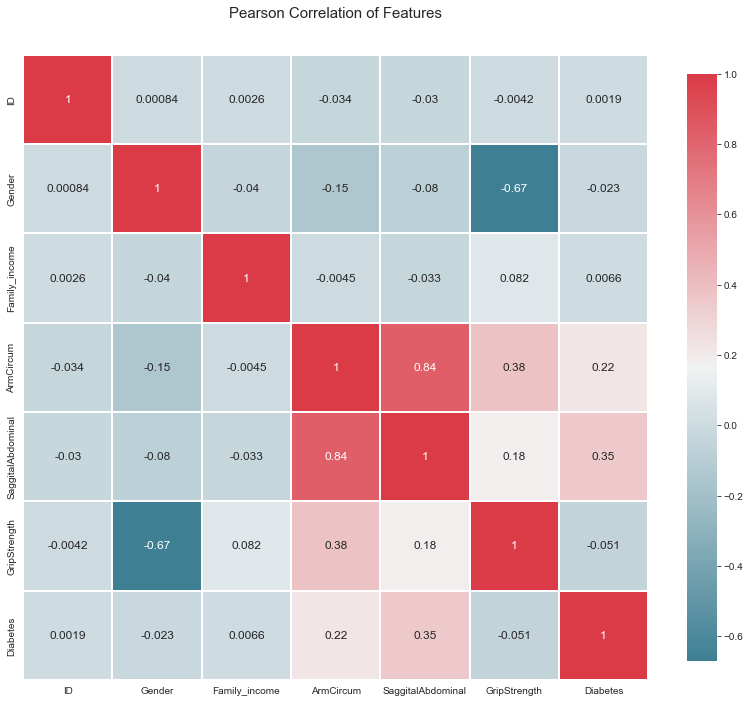

In [17]:
def correlation_heatmap(df):
    _ , ax = plt.subplots(figsize =(14, 12))
    colormap = sns.diverging_palette(220, 10, as_cmap = True)
    
    _ = sns.heatmap(
        df.corr(), 
        cmap = colormap,
        square=True, 
        cbar_kws={'shrink':.9 }, 
        ax=ax,
        annot=True, 
        linewidths=0.1,vmax=1.0, linecolor='white',
        annot_kws={'fontsize':12 }
    )
    
    plt.title('Pearson Correlation of Features', y=1.05, size=15)

correlation_heatmap(df)


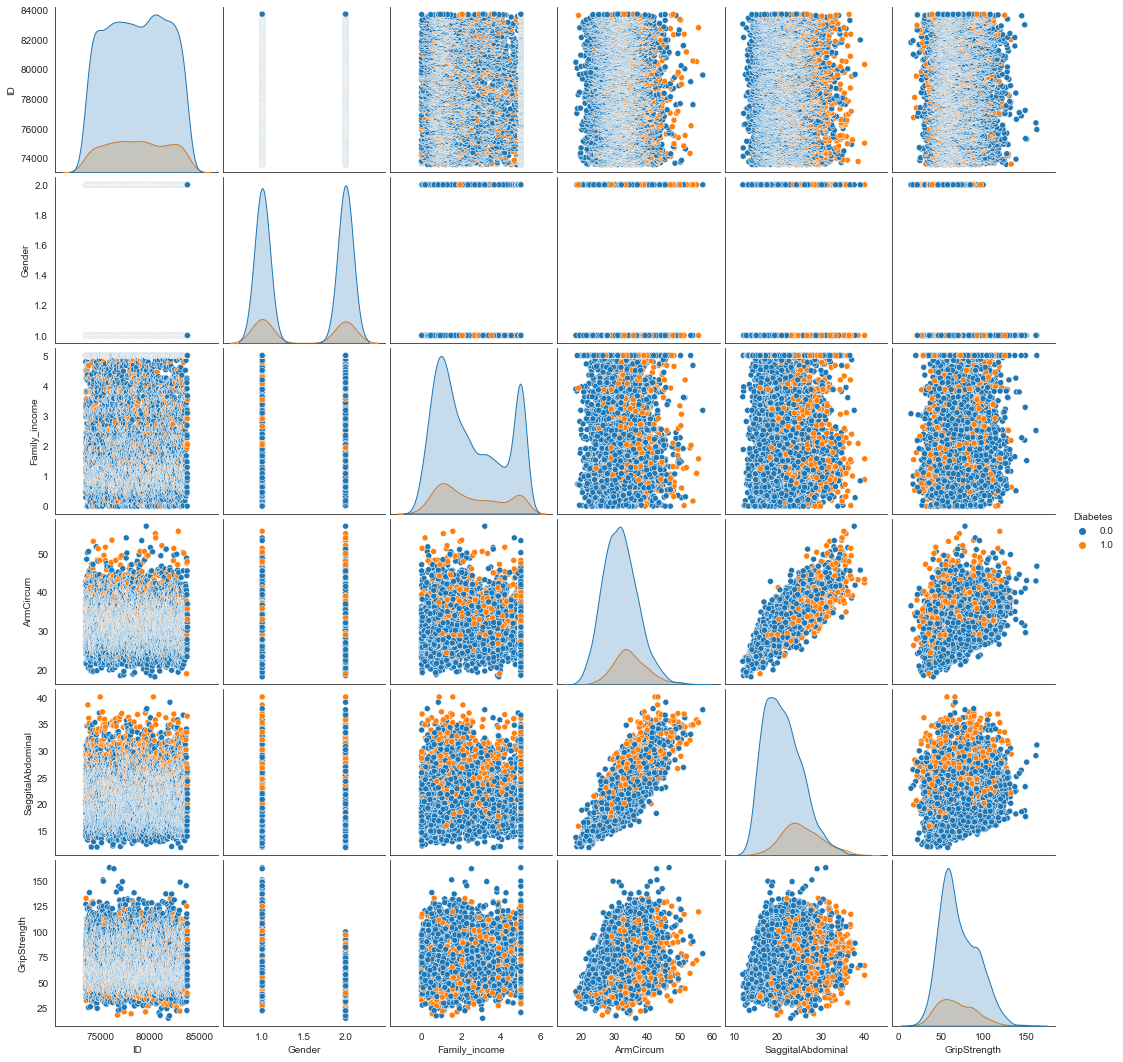

In [18]:
sns.pairplot(df,hue="Diabetes")


<h1>Model</h1>

In [19]:
X = df.drop("Diabetes",axis=1)
y = df["Diabetes"].astype(int)
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=42)


<h1>Logistic Regression</h1>

In [20]:
#creating a pipeline with standard scaler and a classification model
def pipe(model):
    scaler = StandardScaler()
    modell= model
    pipeline = make_pipeline(scaler,modell)
    return pipeline
    
pipeline_logreg=pipe(LogisticRegression())

In [21]:
#Hyperparameter tuning
def tuning(params,pipeline):
    cv=GridSearchCV(pipeline,params)
    cv.fit(X_train,y_train)
    print("best score:" ,cv.best_score_ , "best params:",cv.best_params_)
    return cv
C = np.logspace(-4, 4, 50)
penalty = ['l1', 'l2']
params = {'logisticregression__C':C,'logisticregression__penalty':penalty}
cv_logreg = tuning(params,pipeline_logreg)


c:\Users\PC2\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\PC2\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\PC2\anaconda3\lib\site-packages\sklearn\pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "c:\Users\PC2\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "c:\Users\PC2\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 443, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty

best score: 0.8365289391703559 best params: {'logisticregression__C': 0.0062505519252739694, 'logisticregression__penalty': 'l2'}


c:\Users\PC2\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:922: UserWarning: One or more of the test scores are non-finite: [       nan 0.8316183         nan 0.8316183         nan 0.8316183
        nan 0.8316183         nan 0.8316183         nan 0.8316183
        nan 0.8316183         nan 0.8316183         nan 0.83185194
        nan 0.83302099        nan 0.83465787        nan 0.83652894
        nan 0.83535908        nan 0.83442286        nan 0.83489069
        nan 0.83582636        nan 0.83512406        nan 0.83582555
        nan 0.83488987        nan 0.83325299        nan 0.83255151
        nan 0.83325299        nan 0.83301907        nan 0.8330188
        nan 0.83278543        nan 0.83301907        nan 0.83301907
        nan 0.83301907        nan 0.83278516        nan 0.83278516
        nan 0.8330188         nan 0.8330188         nan 0.8330188
        nan 0.8330188         nan 0.8330188         nan 0.8330188
        nan 0.8330188         nan 0.8330188         nan 0.83

In [22]:

y_pred = cv_logreg.predict(X_test)
#cv.score(X_test,y_test)
confusion_matrix(y_pred,y_test)


array([[889, 164],
       [  7,  10]], dtype=int64)

In [23]:
def evaluation(model):
    
    model.fit(X_train, y_train)
    ypred = model.predict(X_test)
    
    cm = confusion_matrix(y_test, ypred)
    sns.heatmap(cm, annot=True, fmt='d')
    plt.show()
    
    print(classification_report(y_test, ypred))
    """
    N, train_score, val_score = learning_curve(model, X_train, y_train,
                                              cv=4, scoring='accuracy',
                                               train_sizes=np.linspace(0.1, 1, 10))
    
    plt.figure(figsize=(12, 8))
    plt.plot(N, train_score.mean(axis=1), label='train score')
    plt.plot(N, val_score.mean(axis=1), label='validation score')
    plt.legend()
    plt.show()
    """

c:\Users\PC2\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\PC2\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\PC2\anaconda3\lib\site-packages\sklearn\pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "c:\Users\PC2\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "c:\Users\PC2\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 443, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty

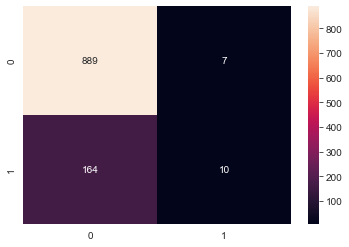

              precision    recall  f1-score   support

           0       0.84      0.99      0.91       896
           1       0.59      0.06      0.10       174

    accuracy                           0.84      1070
   macro avg       0.72      0.52      0.51      1070
weighted avg       0.80      0.84      0.78      1070



In [24]:
evaluation(cv_logreg)

<h1>KNN</h1>

In [25]:
from sklearn.neighbors import KNeighborsClassifier
pipeline_knn = pipe(KNeighborsClassifier())
leaf_size = list(range(1,50))
n_neighbors = list(range(1,30))
p=[1,2]
params={'kneighborsclassifier__n_neighbors': n_neighbors,'kneighborsclassifier__leaf_size':leaf_size,"kneighborsclassifier__p":p}
cv_knn=tuning(params,pipeline_knn)


best score: 0.8339574793682024 best params: {'kneighborsclassifier__leaf_size': 1, 'kneighborsclassifier__n_neighbors': 20, 'kneighborsclassifier__p': 2}


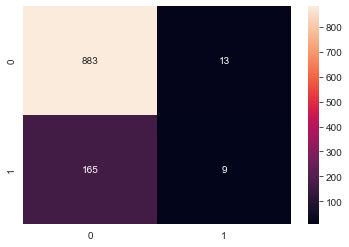

              precision    recall  f1-score   support

           0       0.84      0.99      0.91       896
           1       0.41      0.05      0.09       174

    accuracy                           0.83      1070
   macro avg       0.63      0.52      0.50      1070
weighted avg       0.77      0.83      0.78      1070



In [26]:
evaluation(cv_knn)

<b>KNN and Logistic regression had practically the same accuracy.